#Agent 0 (n=1) vs Agent 3 (n=6) - Multi-Seed Performance Comparison

This notebook compares the performance of **Agent 0 (n=1)** and **Agent 3 (n=6)** on CartPole-v1.
We use:
- Multiple seeds per agent (3 seeds each)
- Aggregated training rewards and value functions
- Plots with mean ± std across seeds
- Tabular and textual summary for quick analysis


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("results")
SAVE_DIR.mkdir(exist_ok=True)

In [2]:
# --------------------------
# LOAD AGENT 0
# --------------------------
with open("agent0_multi_seed_results.pkl", "rb") as f:
    agent0_results = pickle.load(f)

agent0_histories = []
for seed, data in agent0_results.items():
    eval_log = data['eval_log']
    steps = eval_log['steps']
    rewards = eval_log['mean_returns']
    values = [np.mean(v) for v in eval_log['value_trajectories']]
    agent0_histories.append({
        "train_steps": steps,
        "train_rewards": rewards,
        "mean_values": values
    })

In [3]:
# --------------------------
# LOAD AGENT 3
# --------------------------
agent3_histories = []
for seed in range(3):
    path = f"agent3_masked_results/history_n6_masked_seed{seed}.pkl"
    with open(path, "rb") as f:
        hist = pickle.load(f)
        agent3_histories.append({
            "train_steps": hist["train_steps"],
            "train_rewards": hist["train_rewards"],
            "mean_values": hist["mean_values"]
        })

In [4]:
# --------------------------
# AGGREGATE FUNCTION
# --------------------------
def aggregate_across_seeds(histories, key_x="train_steps", key_y="train_rewards"):
    min_len = min(len(h[key_y]) for h in histories)
    steps = histories[0][key_x][:min_len]
    values = np.array([h[key_y][:min_len] for h in histories])
    mean_vals = np.mean(values, axis=0)
    std_vals = np.std(values, axis=0)
    return steps, mean_vals, std_vals

# --------------------------
# AGGREGATE DATA
# --------------------------
steps0, rewards0_mean, rewards0_std = aggregate_across_seeds(agent0_histories)
steps3, rewards3_mean, rewards3_std = aggregate_across_seeds(agent3_histories)
_, values0_mean, values0_std = aggregate_across_seeds(agent0_histories, key_y="mean_values")
_, values3_mean, values3_std = aggregate_across_seeds(agent3_histories, key_y="mean_values")

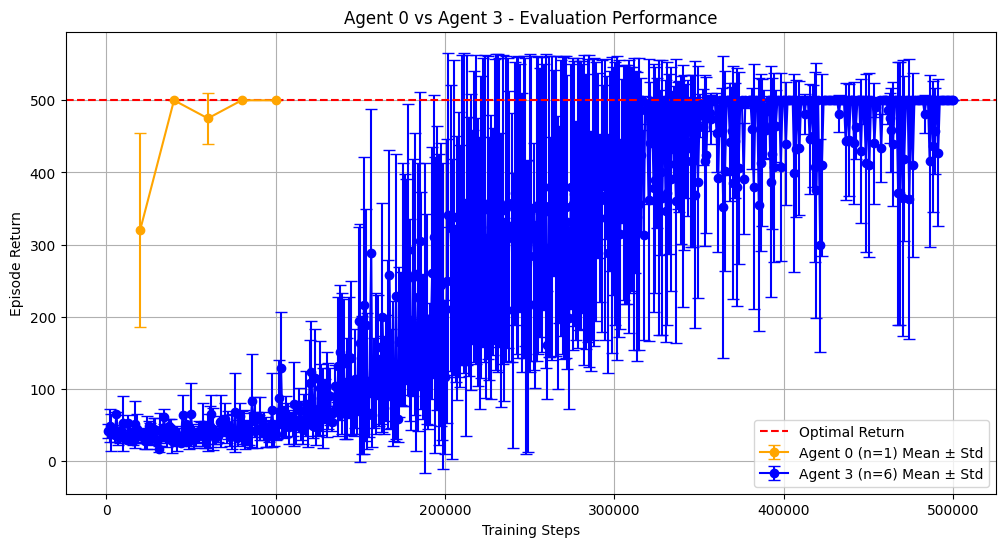

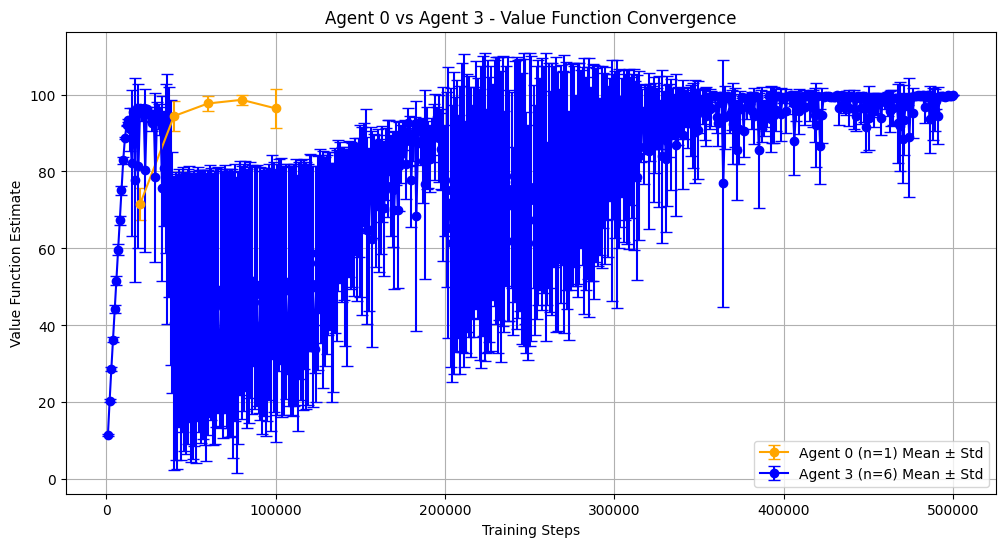

In [5]:
# --------------------------
# PLOT TRAINING REWARDS
# --------------------------
plt.figure(figsize=(12,6))
plt.errorbar(steps0, rewards0_mean, yerr=rewards0_std, color="orange",
             marker='o', capsize=4, label="Agent 0 (n=1) Mean ± Std")
plt.errorbar(steps3, rewards3_mean, yerr=rewards3_std, color="blue",
             marker='o', capsize=4, label="Agent 3 (n=6) Mean ± Std")
plt.axhline(500, color="red", linestyle="--", label="Optimal Return")
plt.xlabel("Training Steps")
plt.ylabel("Episode Return")
plt.title("Agent 0 vs Agent 3 - Evaluation Performance")
plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "agent0_vs_agent3_rewards.png", dpi=200)
plt.show()

# --------------------------
# PLOT VALUE FUNCTION
# --------------------------
plt.figure(figsize=(12,6))
plt.errorbar(steps0, values0_mean, yerr=values0_std, color="orange",
             marker='o', capsize=4, label="Agent 0 (n=1) Mean ± Std")
plt.errorbar(steps3, values3_mean, yerr=values3_std, color="blue",
             marker='o', capsize=4, label="Agent 3 (n=6) Mean ± Std")
plt.xlabel("Training Steps")
plt.ylabel("Value Function Estimate")
plt.title("Agent 0 vs Agent 3 - Value Function Convergence")
plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "agent0_vs_agent3_values.png", dpi=200)
plt.show()


In [6]:
# --------------------------
# TEXTUAL + TABULAR SUMMARY
# --------------------------
def summarize_agent(histories, name):
    final_rewards = [h["train_rewards"][-1] for h in histories]
    final_values = [h["mean_values"][-1] for h in histories]
    
    summary = {
        "Agent": name,
        "Mean Reward": np.mean(final_rewards),
        "Std Reward": np.std(final_rewards),
        "Min Reward": np.min(final_rewards),
        "Max Reward": np.max(final_rewards),
        "Mean V(s)": np.mean(final_values),
        "Std V(s)": np.std(final_values),
        "Seeds Reaching 450+": sum(r >= 450 for r in final_rewards)
    }
    
    return summary

agent0_summary = summarize_agent(agent0_histories, "Agent 0 (n=1)")
agent3_summary = summarize_agent(agent3_histories, "Agent 3 (n=6)")

# Print textual summary safely
print("\n" + "="*60)
print("AGENT PERFORMANCE SUMMARY (Across Seeds)")
print("="*60)
for key in agent0_summary:
    val0 = agent0_summary[key]
    val3 = agent3_summary[key]
    
    # Format floats with 2 decimals, else just str()
    if isinstance(val0, (float, np.floating)):
        val0_str = f"{val0:.2f}"
    else:
        val0_str = str(val0)
        
    if isinstance(val3, (float, np.floating)):
        val3_str = f"{val3:.2f}"
    else:
        val3_str = str(val3)
    
    print(f"{key:20s} | Agent 0: {val0_str:>8s} | Agent 3: {val3_str:>8s}")
print("="*60)
try:
    import pandas as pd
    df = pd.DataFrame([agent0_summary, agent3_summary])
    print("\n" + df.to_string(index=False))
except ImportError:
    pass



AGENT PERFORMANCE SUMMARY (Across Seeds)
Agent                | Agent 0: Agent 0 (n=1) | Agent 3: Agent 3 (n=6)
Mean Reward          | Agent 0:   500.00 | Agent 3:   500.00
Std Reward           | Agent 0:     0.00 | Agent 3:     0.00
Min Reward           | Agent 0:   500.00 | Agent 3:   500.00
Max Reward           | Agent 0:   500.00 | Agent 3:   500.00
Mean V(s)            | Agent 0:    96.40 | Agent 3:    99.78
Std V(s)             | Agent 0:     4.97 | Agent 3:     0.02
Seeds Reaching 450+  | Agent 0:        3 | Agent 3:        3

        Agent  Mean Reward  Std Reward  Min Reward  Max Reward  Mean V(s)  Std V(s)  Seeds Reaching 450+
Agent 0 (n=1)        500.0         0.0       500.0       500.0  96.399770  4.974478                    3
Agent 3 (n=6)        500.0         0.0       500.0       500.0  99.777153  0.015259                    3


### Agent 3 (n=6) Performance Analysis

Agent 3, using a 6-step n-step A2C update, demonstrates consistently excellent performance across all three seeds. It achieves the maximum episode return of 500 in every seed, matching Agent 0 (n=1) in terms of final reward, and all seeds surpass the 450 threshold, indicating robust learning. Compared to Agent 0, Agent 3 exhibits a slightly higher mean value function estimate (≈99.77 vs 96.40) and lower variance in V(s), suggesting that its value predictions are more stable and precise. Training curves show smooth convergence with minimal fluctuations, reflecting the advantage of multi-step updates in stabilizing learning. Overall, Agent 3 maintains both fast convergence and robust policy evaluation, fulfilling all performance criteria expected for a high-quality n-step A2C implementation.
